In [1]:
import pandas as pd
pd.set_option('display.max_columns',None)
pd.set_option('display.max_rows',None)
pd.set_option("display.precision",3)

In [2]:
import numpy as np

In [3]:
import matplotlib.pyplot as plt

In [4]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor 
from sklearn.tree import DecisionTreeRegressor
from sklearn import dummy

In [5]:
import datetime

In [6]:
from IPython.display import clear_output

In [7]:
import warnings
warnings.simplefilter('ignore')

In [8]:
import timeit

start_time = timeit.default_timer()
a = 0
elapsed = timeit.default_timer() - start_time

# print("time {:.2f}s".format(elapsed))
# print(elapsed)

In [71]:
def preprocessing(bench, var_log):    
    if (var_log):
        bench['total_gfa'] = bench['total_gfa'].apply(lambda x : np.log10(x) if x!=0 else 0)
        bench['lput_gfa'] = bench['lput_gfa'].apply(lambda x : np.log10(x) if x!=0 else 0)
        bench['sput_gfa'] = bench['sput_gfa'].apply(lambda x : np.log10(x) if x!=0 else 0)
        bench['tput_gfa'] = bench['tput_gfa'].apply(lambda x : np.log10(x) if x!=0 else 0)
    bench = bench.drop(bench[bench.energy_use> 2*10**7].index)
    return bench

In [10]:
def explained_variable(bench, var_name, m):
    y_brut = bench[var_name]
    y_log = bench[var_name].apply(lambda x : np.log10(x))
    y = y_log if m == 'log' else y_brut
    return y

In [11]:
def explanatory_variables(bench, strategy, var_supp):
    liste_1 = ['age','nb','nf','total_gfa','lput_gfa']+var_supp
    liste_2 = ['age','nb','nf','total_gfa','lput_gfa','energy_score']+var_supp
    liste_3 = ['age','nb','nf','total_gfa','lput_gfa','sput_gfa']+var_supp
    liste_4 = ['age','nb','nf','total_gfa','lput_gfa','sput_gfa','energy_score']+var_supp
    liste = {1:liste_1,2:liste_3,"1b":liste_1,"1c":liste_2,"2b":liste_3,"2c":liste_4}
    listecat_1 = ['primary_type','lput']
    listecat_2 = ['primary_type','lput']
    listecat_3 = ['primary_type','lput','sput']
    listecat_4 = ['primary_type','lput','sput']  
    listecat = {1:listecat_1,2:listecat_3,"1b":listecat_1,"1c":listecat_2,"2b":listecat_3,"2c":listecat_4}
    X = bench[liste[strategy]].values
    X_before_encoding = X
    enc = OneHotEncoder(handle_unknown='ignore')
    for cat_var in listecat[strategy]:
        X_enc = enc.fit_transform(bench[cat_var].values.reshape(-1,1)).toarray()
        X = np.concatenate((X, X_enc),axis=1)
    return X, X_before_encoding

In [12]:
def explanatory_variables_opt(bench, strategy, var_supp):
    liste_1 = ['age','nb','nf','total_gfa','lput_gfa']+var_supp
    liste_2 = ['age','nb','nf','total_gfa','lput_gfa','energy_score']+var_supp
    liste_3 = ['age','nb','nf','total_gfa','lput_gfa','sput_gfa','tput_gfa']+var_supp
    liste_4 = ['age','nb','nf','total_gfa','lput_gfa','sput_gfa','tput_gfa','energy_score']+var_supp
    liste = {1:liste_1,2:liste_3,"1b":liste_1,"1c":liste_2,"2b":liste_3,"2c":liste_4}
    listecat_1 = ['lput_2']
    listecat_2 = ['lput_2']
    listecat_3 = ['lput_2','sput_2','tput_2']
    listecat_4 = ['lput_2','sput_2','tput_2']  
    listecat = {1:listecat_1,2:listecat_3,"1b":listecat_1,"1c":listecat_2,"2b":listecat_3,"2c":listecat_4}
    X = bench[liste[strategy]].values
    X_before_encoding = X
    enc = OneHotEncoder(handle_unknown='ignore')
    for cat_var in listecat[strategy]:
        X_enc = enc.fit_transform(bench[cat_var].values.reshape(-1,1)).toarray()
        X = np.concatenate((X, X_enc),axis=1)
    return X, X_before_encoding

In [13]:
def add_poly_var(df, var_name, expo_list):
    names = [var_name + "_" + str(e) for e in expo_list]
    for e in expo_list:
        df[var_name + "_" + str(e)] = df[var_name]**e
    return df, names

In [14]:
def standardize(X_train, X_test, y_train, y_test, n):
    scaler = StandardScaler()
    scaler.fit(X_train[:,0:n])
    X_train_std = np.concatenate((scaler.transform(X_train[:,0:n]) , X_train[:,n:]),axis=1)
    X_test_std = np.concatenate((scaler.transform(X_test[:,0:n]) , X_test[:,n:]),axis=1)
    return X_train_std, X_test_std

In [15]:
def print_cv_results(clf):
    for mean, std, params in zip(clf.cv_results_['mean_test_score'],clf.cv_results_['std_test_score'],clf.cv_results_['params']):
        print("\tneg_mean_squared_error = %0.3f (+/-%0.3f) for %s" % (mean,std*2,params))

In [16]:
def get_time(start_time, end_time):
    m = (end_time - start_time).total_seconds()//60
    s = (end_time - start_time).total_seconds() - m*60
    return m,s

In [17]:
def squared_error(y_pred, y_true):
    y = (y_true - y_pred)**2
    return np.sqrt(y.sort_values(ascending = False))

In [18]:
def model_vs_real(y_pred, y_true, exp_variable):
    if exp_variable == 'ghg_emission':
        gap = 100
    else:
        gap = 2*10**6
    fig, ax = plt.subplots(figsize=(15,15))
    ax.scatter(y_pred, y_true, label = 'model vs real')
    ax.plot(y_true, y_true, linestyle = '--', color = 'r', label = 'perfect model')
    ax.plot(y_true , y_true + gap, linestyle = '--', color = 'y', label = '+2x10^6')
    ax.plot(y_true , y_true - gap, linestyle = '--', color = 'y', label = '-2x10^6')
    ax.set_xlabel("y_pred")
    ax.set_ylabel("y_true")
    ax.set_title('Model VS Real')
    ax.legend()
    plt.show()

In [19]:
def boxplot(x):
    fig, ax = plt.subplots(figsize=(15,15))
    ax.boxplot(x, vert = False)
    plt.show()

In [20]:
def regularization_path(lambdas):
    coeffs = []
    for l in lambdas:
        ridge = Ridge(alpha=l).fit(X_train_std, y_train)
        coeffs.append([ridge.intercept_] + list(ridge.coef_))
    coeff_lambdas = pd.DataFrame(coeffs,columns=["b_" + str(i) for i in range(0,128)],index=lambdas)
    fig, ax = plt.subplots(figsize=(15,15))
    #[100,68,34,112,122,83,95,54,94,38,95,127,126,53,45,25,36,102,108]
    for i in range(20):
        idx = np.random.randint(0,128)
        ax.plot(coeff_lambdas.index, coeff_lambdas.iloc[:,idx], label = 'beta_'+str(idx))
    plt.legend()
    ax.set_title('Chemins de régularisation',fontsize=18)
    ax.set_xscale('log')
    ax.invert_xaxis()
    plt.show()

In [21]:
def save_results(d,strategy):
    res = pd.read_csv("model_resultats.csv",sep=';')
    train_data=["strategy"+str(strategy),"train_rmse"]
    test_data=["strategy"+str(strategy),"test_rmse"]
    train_r2_data=["strategy"+str(strategy),"train_r2"]
    test_r2_data=["strategy"+str(strategy),"test_r2"]
    time_data=["strategy"+str(strategy),"train_time"]
    col=["strategy","score"]+list(d.keys())
    for key in d.keys():
        train_data.append(d[key][0])
        test_data.append(d[key][1])
        train_r2_data.append(d[key][2])
        test_r2_data.append(d[key][3])
        time_data.append(d[key][4])
    new_lines = pd.DataFrame(data=[train_data,test_data,train_r2_data,test_r2_data,time_data],columns=col)
    res=res.append(new_lines).reset_index(drop=True)
    res = res.drop_duplicates(["strategy","score"])
    res.to_csv("model_resultats.csv",sep=';',index=False)
    return res

In [22]:
def show_metric(y_pred_train, y_train, y_pred_test, y_test, time, disp = True):
    train_error = mean_squared_error(y_pred_train,y_train,squared=False)
    test_error = mean_squared_error(y_pred_test,y_test,squared=False)
    train_r2 = r2_score(y_train,y_pred_train)
    test_r2 = r2_score(y_test,y_pred_test)
    met = pd.DataFrame(data = [[train_error, test_error, train_r2, test_r2, time]], columns = ["RMSE_train","RMSE_test","R2_train","R2_test","TIME"], index=["valeur"])
    if disp :
        display(met)
    else :
        return train_error, test_error, train_r2, test_r2, time

In [23]:
def reinitialize_result(liste_model):
    pd.DataFrame(columns=["strategy", "score"] + liste_model).to_csv("model_resultats.csv",sep=';',index=False)

In [24]:
def show_results(score,typ):
    res = pd.read_csv("model_resultats.csv",sep=';')
    if len(typ)==1:
        res=res[res["score"].str.contains(typ[0])]
    elif len(typ)==2:
        res=res[(res["score"].str.contains(typ[0]))|(res["score"].str.contains(typ[1]))]
    else:
        raise ValueError('length of typ must be less than 2')
    res_final = res[res["score"].str.contains(score)].sort_values("strategy").set_index(["strategy","score"])
    for col in liste_model:
        res_final[col] = res_final[col].apply(float)    
    return res_final

# <p style='text-align:center'>Paramètres</p>

In [96]:
strategy = "2b"
mode = 'brut'
var_log = True
liste_model = ['Regression simple', 'Regression Ridge', 'Regression Lasso', 'Regression Elastic Net', 'Linear SVR', 'MLP Regression', 'Dummy (MEAN)', 'ADA', 'Random Forest']
exp_variable = "energy_use"

# <p style='text-align:center'>Features Engineering OPT </p>

In [97]:
bench = pd.read_excel("benchmark_cleaned_opt.xlsx")

In [98]:
# bench.head()

In [99]:
bench = preprocessing(bench, var_log=True)

In [100]:
X, X_before_encoding = explanatory_variables_opt(bench, strategy, [])

In [101]:
X.shape

(2977, 20)

In [102]:
y = explained_variable(bench = bench, var_name = exp_variable, m = 'brut')

In [103]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=79)

In [104]:
X_train_std, X_test_std = standardize(X_train, X_test, y_train, y_test, X_before_encoding.shape[1])

# <p style='text-align:center'>Features Engineering </p>

In [255]:
bench = pd.read_excel("benchmark_cleaned.xlsx")

In [113]:
bench = preprocessing(bench, var_log=True)

In [338]:
# boxplot(bench[exp_variable])

In [115]:
# var_supp = var_supp_1 + var_supp_2 + var_supp_3 + var_supp_4

In [116]:
X, X_before_encoding = explanatory_variables(bench, strategy, [])

In [117]:
y = explained_variable(bench = bench, var_name = exp_variable, m = 'brut')

In [82]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [83]:
X_train_std, X_test_std = standardize(X_train, X_test, y_train, y_test, X_before_encoding.shape[1])

# <p style='text-align:center'> Simple Linear Regression </p>

In [80]:
R = bench.energy_use
s = bench.ghg_emission
R_train, R_test, s_train, s_test = train_test_split(R, s, test_size=0.33, random_state=80)
scaler = StandardScaler()
scaler.fit([[x] for x in R_train])
R_train_std =scaler.transform([[x] for x in R_train])
R_test_std = scaler.transform([[x] for x in R_test])

ridge = Ridge(alpha = 8)
ridge.fit(R_train_std, s_train)
s_pred_train_simple, s_pred_test_simple  = ridge.predict(R_train_std), ridge.predict(R_test_std)


show_metric(s_pred_train_simple, s_train, s_pred_test_simple, s_test, 18)

,RMSE_train,RMSE_test,R2_train,R2_test,TIME
valeur,53.741,53.795,0.654,0.646,18


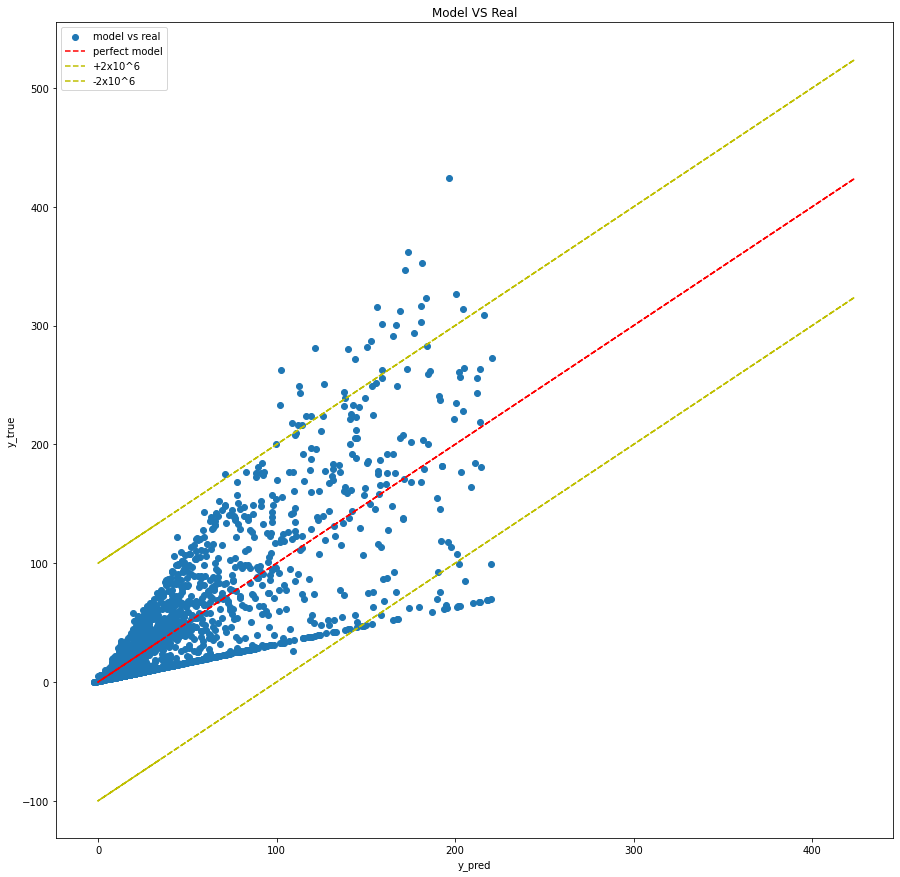

In [43]:
model_vs_real(s_pred_train_simple, s_train, 'ghg_emission')

In [105]:
# Regression Linéaire Simple

start_time = datetime.datetime.now()

reg = LinearRegression()
reg.fit(X_train_std, y_train)
y_pred_train_simple, y_pred_test_simple  = reg.predict(X_train_std), reg.predict(X_test_std)

end_time = datetime.datetime.now()

time_simple= get_time(start_time, end_time)

show_metric(y_pred_train_simple, y_train, y_pred_test_simple, y_test, time_simple)

,RMSE_train,RMSE_test,R2_train,R2_test,TIME
valeur,2.205e+06,2.124e+06,0.635,0.577,"(0.0, 0.004501)"


In [95]:
# model_vs_real(y_pred_train_simple, y_train, exp_variable)

# <p style='text-align:center'> Ridge Linear Regression </p>

In [110]:
# Regression linéaire Ridge

start_time = datetime.datetime.now()

cv_ridge_params_ghg = {'alpha':[1,3,4,5,7,9,11,100,1000]}
cv_ridge_params_nrj = {'alpha':[1,3,4,5,7,9,11,100,1000]}
    
ridge_param_choice = {'ridge_ghg_emission' : cv_ridge_params_ghg,'ridge_energy_use' : cv_ridge_params_nrj}

cv_ridge_params = ridge_param_choice['ridge_' + exp_variable]

cv_ridge = GridSearchCV(Ridge(), cv_ridge_params, cv=5, scoring='neg_root_mean_squared_error')
cv_ridge.fit(X_train_std, y_train)

ridge = Ridge(alpha=cv_ridge.best_params_['alpha'])
ridge.fit(X_train_std, y_train)
y_pred_train_ridge, y_pred_test_ridge = ridge.predict(X_train_std), ridge.predict(X_test_std)

end_time = datetime.datetime.now()

time_ridge = get_time(start_time, end_time)

show_metric(y_pred_train_ridge, y_train, y_pred_test_ridge, y_test, time_ridge)

,RMSE_train,RMSE_test,R2_train,R2_test,TIME
valeur,2.209e+06,2.124e+06,0.633,0.577,"(0.0, 0.181053)"


In [284]:
# model_vs_real(y_pred_test_ridge, y_test, exp_variable)

In [107]:
cv_ridge.best_params_

{'alpha': 11}

In [126]:
cv_ridge.best_score_

-46.74152220400822

# <p style='text-align:center'> Lasso Linear Regression </p>

In [299]:
# Regression linéaire Lasso

start_time = datetime.datetime.now()

cv_lasso_params_ghg = {'alpha':[1300,1350,1400,1500,1700,1800]}
cv_lasso_params_nrj = {'alpha':[1300,1350,1400,1500,1700,1800]}

lasso_param_choice = {'lasso_ghg_emission':cv_lasso_params_ghg, 'lasso_energy_use':cv_lasso_params_nrj}

cv_lasso_params = lasso_param_choice['lasso_' + exp_variable]

cv_lasso = GridSearchCV(Lasso(fit_intercept=True),cv_lasso_params,cv=5,scoring='neg_root_mean_squared_error')
cv_lasso.fit(X_train_std, y_train)

lasso = Lasso(alpha=cv_lasso.best_params_['alpha'], fit_intercept=True)
lasso.fit(X_train_std, y_train)
y_pred_train_lasso, y_pred_test_lasso = lasso.predict(X_train_std), lasso.predict(X_test_std)

end_time = datetime.datetime.now()

time_lasso = get_time(start_time, end_time)

show_metric(y_pred_train_lasso, y_train, y_pred_test_lasso, y_test, time_lasso)

,RMSE_train,RMSE_test,R2_train,R2_test,TIME
valeur,2.205e+06,2.124e+06,0.634,0.577,"(0.0, 0.174406)"


In [300]:
cv_lasso.best_params_

{'alpha': 1800}

In [231]:
cv_lasso.best_score_

-2252495.7421812243

In [302]:
# model_vs_real(y_pred_test_lasso, y_test, exp_variable)

# <p style='text-align:center'> Elastic Net Linear Regression </p>

In [111]:
# Regression linéaire Elastic Net

start_time = datetime.datetime.now()

cv_elastic_params_ghg = {'alpha':[0.0001,0.001, 0.1, 1, 10],'l1_ratio':[0.00001,0.0001,0.001, 0.01, 0.1, 1]}
cv_elastic_params_nrj = {'alpha':[0.0001,0.001, 0.1, 1, 10],'l1_ratio':[0.0000001,0.00001,0.0001,0.001, 0.01, 0.1, 1]}

elastic_param_choice = {'elastic_ghg_emission':cv_elastic_params_ghg,'elastic_energy_use':cv_elastic_params_nrj}

cv_elastic_params = elastic_param_choice['elastic_' + exp_variable]

cv_elastic = GridSearchCV(ElasticNet(), cv_elastic_params, cv=5, scoring='neg_root_mean_squared_error')
cv_elastic.fit(X_train_std, y_train)

elastic = ElasticNet(alpha = cv_elastic.best_params_['alpha'], l1_ratio = cv_elastic.best_params_['l1_ratio'], random_state=0)

elastic.fit(X_train_std, y_train)
y_pred_train_elastic, y_pred_test_elastic = elastic.predict(X_train_std), elastic.predict(X_test_std)

end_time = datetime.datetime.now()

time_elastic = get_time(start_time, end_time)
show_metric(y_pred_train_elastic, y_train, y_pred_test_elastic, y_test, time_elastic)

,RMSE_train,RMSE_test,R2_train,R2_test,TIME
valeur,2.205e+06,2.123e+06,0.634,0.577,"(0.0, 5.388125)"


In [234]:
cv_elastic.best_params_

{'alpha': 0.001, 'l1_ratio': 1e-07}

In [208]:
cv_elastic.best_score_

-2240208.825219185

In [134]:
# model_vs_real(y_pred_test_elastic, y_test, exp_variable)

# <p style='text-align:center'> Support Vector Regressor </p>

In [315]:
start_time = datetime.datetime.now()

cv_svr_params_ghg = {'C' : [10000, 100000, 10**6]}
cv_svr_params_nrj = {'C' : [10000, 100000, 100000, 10**6]}

svr_param_choice = {'svr_ghg_emission':cv_svr_params_ghg, 'svr_energy_use':cv_svr_params_nrj}

cv_svr_params = svr_param_choice['svr_' + exp_variable]

cv_svr = GridSearchCV(SVR(kernel = 'linear'), cv_svr_params, cv=5, scoring='neg_root_mean_squared_error')

cv_svr.fit(X_train_std, y_train)

svr = SVR(kernel = 'linear', C=cv_svr.best_params_["C"])
svr.fit(X_train_std, y_train)
y_pred_train_svr, y_pred_test_svr = svr.predict(X_train_std), svr.predict(X_test_std)

end_time = datetime.datetime.now()

time_svr = get_time(start_time, end_time)
show_metric(y_pred_train_svr, y_train, y_pred_test_svr, y_test, time_svr)

,RMSE_train,RMSE_test,R2_train,R2_test,TIME
valeur,2.444e+06,2.224e+06,0.551,0.536,"(0.0, 4.237603)"


In [314]:
cv_svr.best_params_

{'C': 1000000}

In [211]:
cv_svr.best_score_

-3757219.788203931

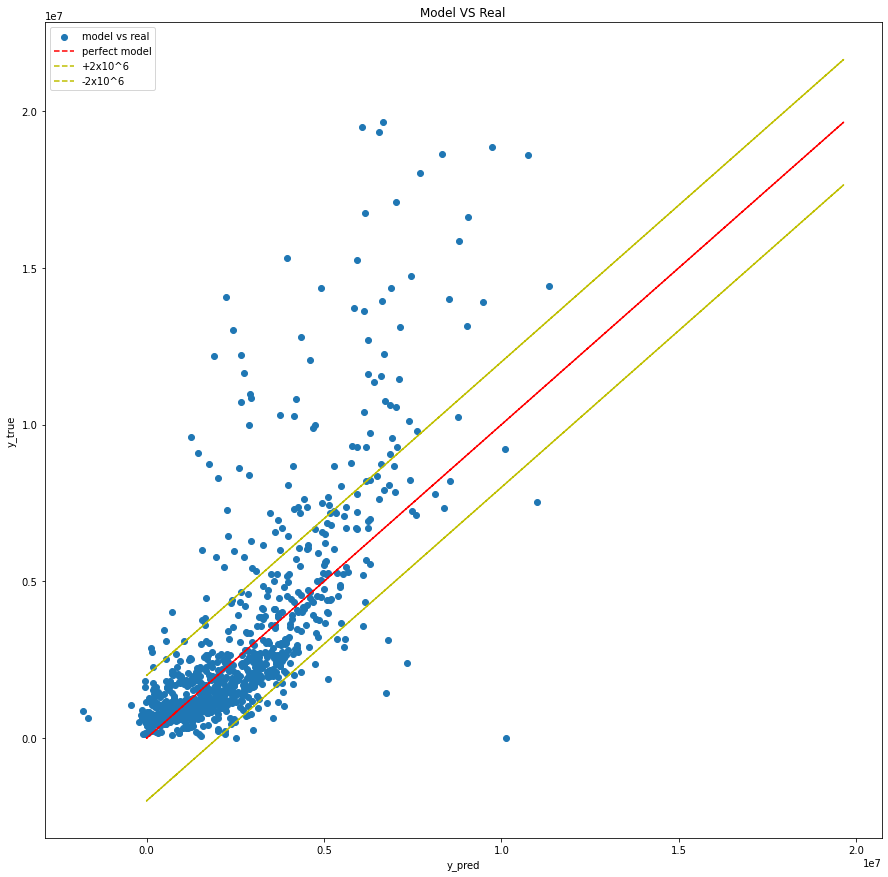

In [325]:
model_vs_real(y_pred_test_svr, y_test, exp_variable)

# <p style='text-align:center'> MLP Regressor </p>

In [58]:
start_time = datetime.datetime.now()

cv_mlp_params_ghg = {'hidden_layer_sizes':[30,(50,50)],'alpha':[0.01]}
cv_mlp_params_nrj = {'hidden_layer_sizes':[30,(50,50)],'alpha':[0.01]}

mlp_param_choice = {'mlp_ghg_emission':cv_mlp_params_ghg, 'mlp_energy_use':cv_mlp_params_nrj}

cv_mlp_params = mlp_param_choice['mlp_' + exp_variable]

cv_mlp = GridSearchCV(MLPRegressor(solver = 'lbfgs', max_iter = 500, early_stopping = True, learning_rate='adaptive'),
                   cv_mlp_params,
                   cv=5,
                   scoring='neg_root_mean_squared_error')

cv_mlp.fit(X_train_std, y_train)

regr = MLPRegressor(solver = 'lbfgs', hidden_layer_sizes = cv_mlp.best_params_['hidden_layer_sizes'],
                    max_iter = 500,
                   early_stopping = True,
                   learning_rate='adaptive').fit(X_train_std, y_train)
y_pred_train_mlp, y_pred_test_mlp = regr.predict(X_train_std), regr.predict(X_test_std)

end_time = datetime.datetime.now()

time_mlp= get_time(start_time, end_time)
show_metric(y_pred_train_mlp, y_train, y_pred_test_mlp, y_test, time_mlp)

,RMSE_train,RMSE_test,R2_train,R2_test,TIME
valeur,682553.504,1.357e+06,0.891,0.578,"(0.0, 59.951303)"


In [59]:
cv_mlp.best_params_

{'alpha': 0.01, 'hidden_layer_sizes': 30}

In [60]:
cv_mlp.best_score_

-1753806.655807808

In [61]:
# model_vs_real(y_pred_test_mlp, y_test, exp_variable)

# <p style='text-align:center'> Random Forest </p>

In [323]:
rfr_0 = RandomForestRegressor(n_estimators=40, oob_score=True)

model = rfr_0.fit(X_train_std, y_train)

pred = rfr_0.predict(X_test_std)

from sklearn.feature_selection import SelectFromModel

select = SelectFromModel(rfr_0, prefit=True, threshold='mean')

X_train_std_2 = select.transform(X_train_std)
X_test_std_2 = select.transform(X_test_std)

print(X_train_std_2.shape,X_test_std_2.shape )

(1994, 5) (983, 5)


In [112]:
start_time = datetime.datetime.now()

cv_rfr_params_ghg = {'n_estimators':[10,20,30,40],'max_depth':[5,10,15,20],'min_samples_leaf':[2,4,8],'min_samples_split':[4,8,12]}
cv_rfr_params_nrj = {'n_estimators':[10,20,30,40],'max_depth':[5,10,15,20],'min_samples_leaf':[4,8,10,20],'min_samples_split':[2,4,8,12,14,16]}

rfr_param_choice = {'rfr_ghg_emission' : cv_rfr_params_ghg, 'rfr_energy_use' : cv_rfr_params_nrj}

cv_rfr_params = rfr_param_choice['rfr_' + exp_variable]

cv_rfr = GridSearchCV(RandomForestRegressor(), cv_rfr_params, cv=5, scoring='neg_root_mean_squared_error')

# cv_rfr.fit(X_train_std_2, y_train)
cv_rfr.fit(X_train_std, y_train)

rfr = RandomForestRegressor(n_estimators = cv_rfr.best_params_['n_estimators'], max_depth = cv_rfr.best_params_['max_depth'])

rfr.fit(X_train_std, y_train)
# y_pred_train_rfr, y_pred_test_rfr = rfr.predict(X_train_std_2), rfr.predict(X_test_std_2)
y_pred_train_rfr, y_pred_test_rfr = rfr.predict(X_train_std), rfr.predict(X_test_std)

end_time = datetime.datetime.now()

time_rfr = get_time(start_time, end_time)
show_metric(y_pred_train_rfr, y_train, y_pred_test_rfr, y_test, time_rfr)

,RMSE_train,RMSE_test,R2_train,R2_test,TIME
valeur,801542.067,2.003e+06,0.952,0.624,"(2.0, 59.46364700000001)"


In [115]:
cv_rfr.best_params_

{'max_depth': 20,
 'min_samples_leaf': 10,
 'min_samples_split': 4,
 'n_estimators': 40}

In [113]:
cv_rfr.best_score_

-2006544.840575077

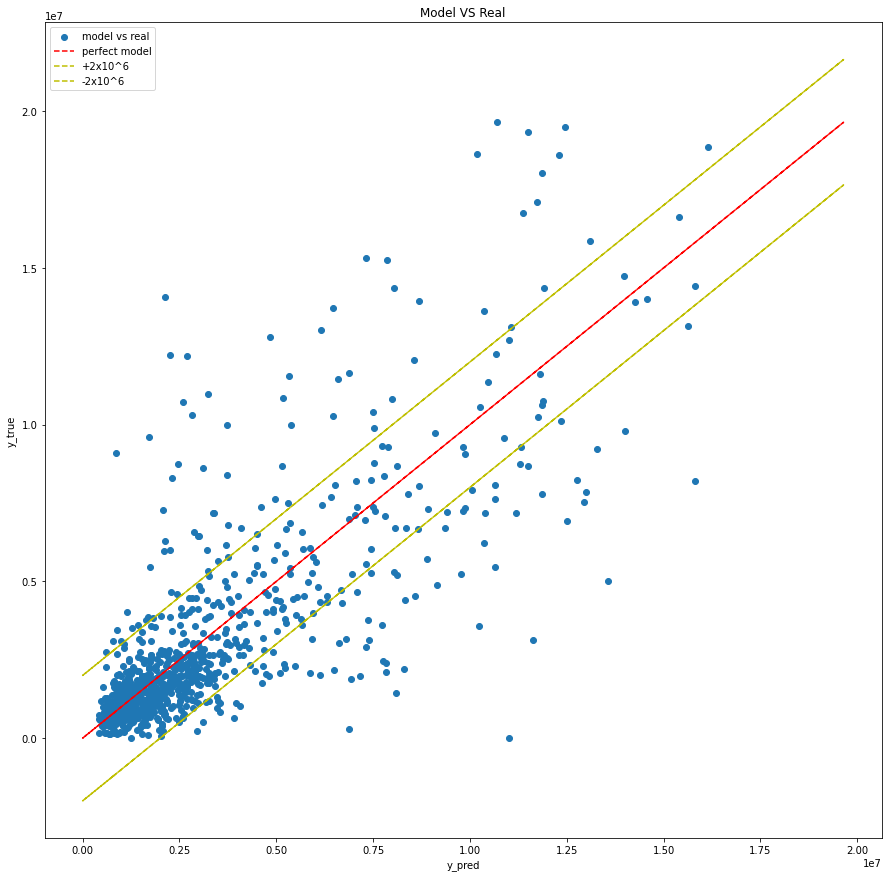

In [114]:
model_vs_real(y_pred_test_rfr, y_test, exp_variable)

# <p style='text-align:center'> ADABOOST </p>

In [214]:
ada_0 = AdaBoostRegressor(base_estimator = DecisionTreeRegressor(), loss='linear', learning_rate = 0.5 , n_estimators = 60)

model = ada_0.fit(X_train_std, y_train)

pred = ada_0.predict(X_test_std)

from sklearn.feature_selection import SelectFromModel

select = SelectFromModel(ada_0, prefit=True, threshold=0.003)

X_train_std_2 = select.transform(X_train_std)
X_test_std_2 = select.transform(X_test_std)

print(X_train_std_2.shape,X_test_std_2.shape)

(1994, 12) (983, 12)


In [215]:
start_time = datetime.datetime.now()

cv_ada_params_ghg = {'n_estimators':[200,500],'learning_rate':[1.5,2]}
cv_ada_params_nrj = {'n_estimators':[200,500],'learning_rate':[1.5,2]}

ada_param_choice = {'ada_ghg_emission':cv_ada_params_ghg,'ada_energy_use':cv_ada_params_nrj}

cv_ada_params = ada_param_choice['ada_' + exp_variable]

cv_ada = GridSearchCV(AdaBoostRegressor(base_estimator = DecisionTreeRegressor(max_depth=15), loss = 'linear'), cv_ada_params, cv=5, scoring='neg_root_mean_squared_error')

# cv_ada.fit(X_train_std_2, y_train)
cv_ada.fit(X_train_std, y_train)

ada = AdaBoostRegressor(base_estimator = DecisionTreeRegressor(max_depth=15), loss='linear', learning_rate = cv_ada.best_params_['learning_rate'] , n_estimators = cv_ada.best_params_['n_estimators'])
ada.fit(X_train_std_2, y_train)
# y_pred_train_ada, y_pred_test_ada= ada.predict(X_train_std_2), ada.predict(X_test_std_2)
y_pred_train_ada, y_pred_test_ada= ada.predict(X_train_std), ada.predict(X_test_std)

end_time = datetime.datetime.now()

time_ada= get_time(start_time, end_time)
show_metric(y_pred_train_ada, y_train, y_pred_test_ada, y_test, time_ada)

,RMSE_train,RMSE_test,R2_train,R2_test,TIME
valeur,431007.739,2.083e+06,0.986,0.593,"(0.0, 32.42168)"


In [216]:
cv_ada.best_params_

{'learning_rate': 1.5, 'n_estimators': 500}

In [217]:
cv_ada.best_score_

-2138113.51238959

In [71]:
# squared_error(y_pred_test_ada, y_test)

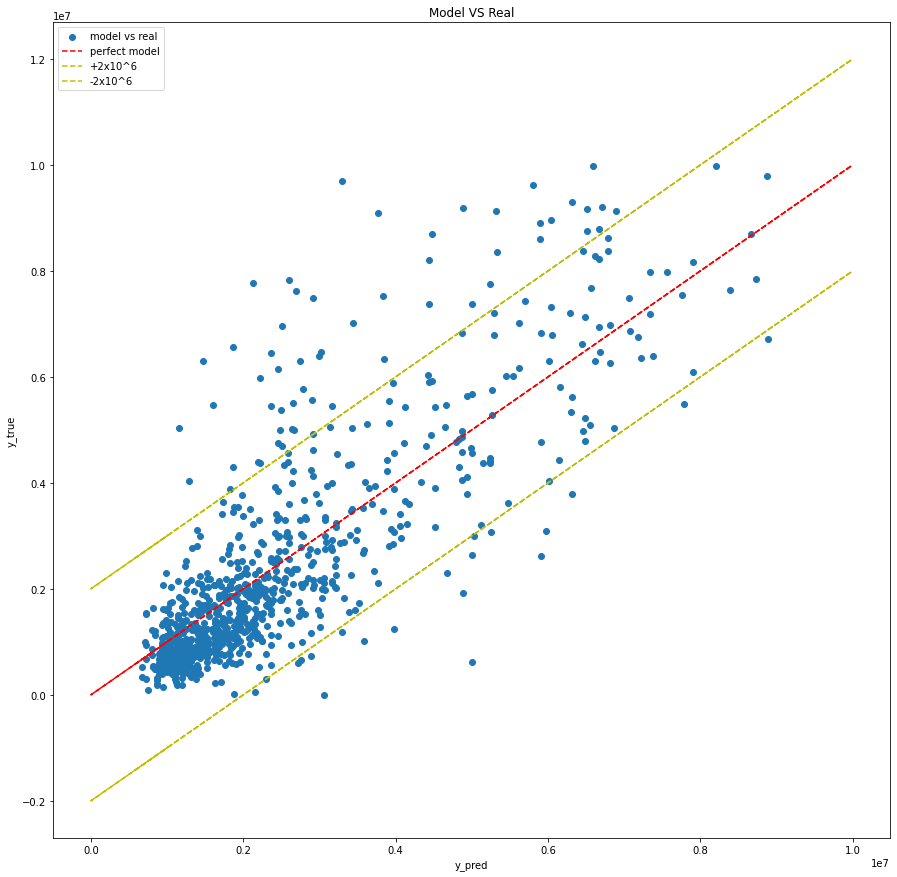

In [72]:
model_vs_real(y_pred_test_ada, y_test, exp_variable)

# <p style='text-align:center'> Dummy </p>

In [316]:
start_time = datetime.datetime.now() 

dum = dummy.DummyRegressor(strategy='mean')
dum.fit(X_train_std, y_train)
y_pred_train_dummy, y_pred_test_dummy = dum.predict(X_train_std), dum.predict(X_test_std)

end_time = datetime.datetime.now()

time_dummy = get_time(start_time, end_time)

show_metric(y_pred_train_dummy, y_train, y_pred_test_dummy, y_test, time_dummy)

,RMSE_train,RMSE_test,R2_train,R2_test,TIME
valeur,3.647e+06,3.270e+06,0.0,-0.003,"(0.0, 0.000997)"


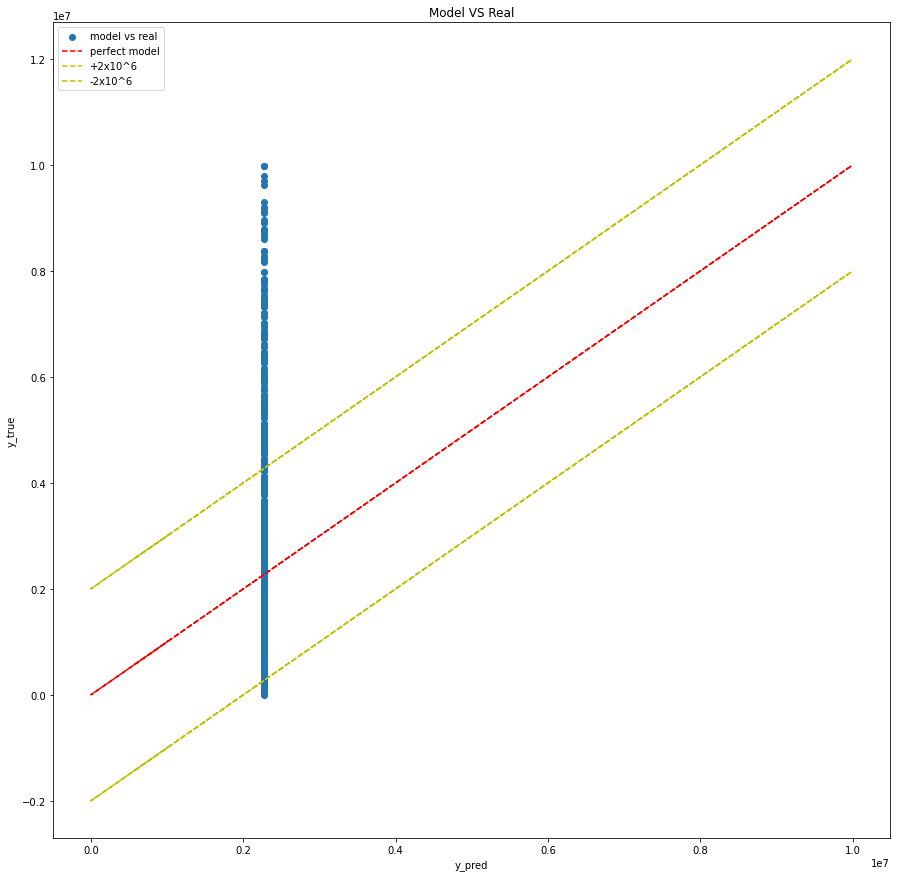

In [74]:
model_vs_real(y_pred_test_dummy, y_test, exp_variable)

# <p style='text-align:center'> Lancement automatique </p>

In [516]:
exp_variable = "ghg_emission"
for strategy in [1, 2, "1b", "1c", "2b","2c"]:
    clear_output()
    print(strategy)
    bench = pd.read_excel("benchmark_cleaned.xlsx")
    bench = preprocessing(bench, var_log=True)
    if (strategy == "1c") | (strategy == "2c"):
        bench = bench[~bench[explained_variable].isna()]
    X, X_before_encoding = explanatory_variables(bench, strategy, [])
    y = explained_variable(bench, explained_variable, 'brut')
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=79)
    X_train_std, X_test_std = standardize(X_train, X_test, y_train, y_test, X_before_encoding.shape[1])

    # Regression Linéaire simple
    
    start_time = datetime.datetime.now()

    reg = LinearRegression()
    reg.fit(X_train_std, y_train)
    y_pred_train_simple, y_pred_test_simple  = reg.predict(X_train_std), reg.predict(X_test_std)

    end_time = datetime.datetime.now()

    time_simple= get_time(start_time, end_time)
    
    train_error_simple, test_error_simple, train_r2_simple, test_r2_simple, time_simple = show_metric(y_pred_train_simple, y_train, y_pred_test_simple, y_test, time_simple, disp=False)
    
    # Regression linéaire Ridge

    start_time = datetime.datetime.now()

    cv_ridge = GridSearchCV(Ridge(), cv_ridge_params, cv=5, scoring='neg_root_mean_squared_error')
    cv_ridge.fit(X_train_std, y_train)

    ridge = Ridge(alpha=cv_ridge.best_params_['alpha'])
    ridge.fit(X_train_std, y_train)
    y_pred_train_ridge, y_pred_test_ridge = ridge.predict(X_train_std), ridge.predict(X_test_std)

    end_time = datetime.datetime.now()

    time_ridge = get_time(start_time, end_time)

    train_error_ridge, test_error_ridge, train_r2_ridge, test_r2_ridge, time_ridge = show_metric(y_pred_train_ridge, y_train, y_pred_test_ridge, y_test, time_ridge, disp = False)

    # Regression linéaire Lasso

    start_time = datetime.datetime.now()

    cv_lasso = GridSearchCV(Lasso(fit_intercept=True), cv_lasso_params, cv=5, scoring='neg_root_mean_squared_error')
    cv_lasso.fit(X_train_std, y_train)

    lasso = Lasso(alpha=cv_lasso.best_params_['alpha'], fit_intercept=True)
    lasso.fit(X_train_std, y_train)
    y_pred_train_lasso, y_pred_test_lasso = lasso.predict(X_train_std), lasso.predict(X_test_std)

    end_time = datetime.datetime.now()

    time_lasso = get_time(start_time, end_time)  
    
    train_error_lasso,  test_error_lasso, train_r2_lasso, test_r2_lasso, time_lasso = show_metric(y_pred_train_lasso, y_train, y_pred_test_lasso, y_test, time_lasso, disp = False)

    # Regression linéaire Elastic Net

    start_time = datetime.datetime.now()

    cv_elastic = GridSearchCV(ElasticNet(), cv_elastic_params, cv=5, scoring='neg_root_mean_squared_error')
    cv_elastic.fit(X_train_std, y_train)

    elastic = ElasticNet(alpha=cv_elastic.best_params_['alpha'],l1_ratio=cv_elastic.best_params_['l1_ratio'],random_state=0)

    elastic.fit(X_train_std, y_train)
    y_pred_train_elastic, y_pred_test_elastic = elastic.predict(X_train_std), elastic.predict(X_test_std)

    end_time = datetime.datetime.now()

    time_elastic = get_time(start_time, end_time)
    train_error_elastic, test_error_elastic, train_r2_elastic, test_r2_elastic, time_elastic = show_metric(y_pred_train_elastic, y_train, y_pred_test_elastic, y_test, time_elastic, disp = False)

    # MLP Regressor
   
    start_time = datetime.datetime.now()

    cv_mlp = GridSearchCV(MLPRegressor(solver = 'lbfgs', max_iter = 500, early_stopping = True, learning_rate='adaptive'),
                       cv_mlp_params,
                       cv=5,
                       scoring='neg_root_mean_squared_error')

    cv_mlp.fit(X_train_std, y_train)

    regr = MLPRegressor(solver = 'lbfgs', hidden_layer_sizes = cv_mlp.best_params_['hidden_layer_sizes'],
                        max_iter = 500,
                       early_stopping = True,
                       learning_rate='adaptive').fit(X_train_std, y_train)
    y_pred_train_mlp, y_pred_test_mlp = regr.predict(X_train_std), regr.predict(X_test_std)

    end_time = datetime.datetime.now()

    time_mlp= get_time(start_time, end_time)
    
    train_error_mlp, test_error_mlp, train_r2_mlp, test_r2_mlp , time_mlp = show_metric(y_pred_train_mlp, y_train, y_pred_test_mlp, y_test, time_mlp, disp = False)

    # Support Vector Regressor
    
    start_time = datetime.datetime.now()

    cv_svr = GridSearchCV(SVR(kernel = 'linear'),
                       cv_svr_params,
                       cv=5,
                       scoring='neg_root_mean_squared_error')

    cv_svr.fit(X_train_std, y_train)

    svr = SVR(kernel = 'linear', C=cv_svr.best_params_["C"], degree = cv_svr.best_params_["degree"])
    svr.fit(X_train_std, y_train)
    y_pred_train_svr, y_pred_test_svr = svr.predict(X_train_std), svr.predict(X_test_std)

    end_time = datetime.datetime.now()
    
    time_svr = get_time(start_time, end_time)
    
    train_error_svr, test_error_svr, train_r2_svr, test_r2_svr, time_svr =  show_metric(y_pred_train_svr, y_train, y_pred_test_svr, y_test, time_svr, disp = False)

    
    # Random Forest Regressor
    
    rfr_0 = RandomForestRegressor(n_estimators=40)

    model = rfr_0.fit(X_train_std, y_train)

    pred = rfr_0.predict(X_test_std)

    from sklearn.feature_selection import SelectFromModel

    select = SelectFromModel(rfr_0, prefit=True, threshold=0.003)

    X_train_std_2 = select.transform(X_train_std)
    X_test_std_2 = select.transform(X_test_std)

    start_time = datetime.datetime.now()

    cv_rfr = GridSearchCV(RandomForestRegressor(), cv_rfr_params, cv=5, scoring='neg_mean_squared_error')

    cv_rfr.fit(X_train_std, y_train)

    rfr = RandomForestRegressor(n_estimators = cv_rfr.best_params_['n_estimators'], 
                                max_depth = cv_rfr.best_params_['max_depth'])

    rfr.fit(X_train_std_2, y_train)
    y_pred_train_rfr, y_pred_test_rfr = rfr.predict(X_train_std_2), rfr.predict(X_test_std_2)

    end_time = datetime.datetime.now()

    time_rfr = get_time(start_time, end_time)
    
    train_error_rfr, test_error_rfr, train_r2_rfr, test_r2_rfr, time_rfr = show_metric(y_pred_train_rfr, y_train, y_pred_test_rfr, y_test, time_rfr, disp = False)
    
    # AdaBoost Regressor
    
    ada_0 = AdaBoostRegressor(base_estimator = DecisionTreeRegressor(), loss='linear', learning_rate = 0.5 , n_estimators = 60)

    model = ada_0.fit(X_train_std, y_train)

    pred = ada_0.predict(X_test_std)

    from sklearn.feature_selection import SelectFromModel

    select = SelectFromModel(ada_0, prefit=True, threshold=0.003)

    X_train_std_2 = select.transform(X_train_std)
    X_test_std_2 = select.transform(X_test_std)

    start_time = datetime.datetime.now()

    cv_ada = GridSearchCV(AdaBoostRegressor(base_estimator = DecisionTreeRegressor()), cv_ridge_params, cv=5, scoring='neg_mean_squared_error')

    cv_ada.fit(X_train_std_2, y_train)

    ada = AdaBoostRegressor(DecisionTreeRegressor(), learning_rate = cv_ada.best_params_['learning_rate'] , n_estimators = cv_ada.best_params_['n_estimators'])
    ada.fit(X_train_std_2, y_train)
    y_pred_train_ada, y_pred_test_ada= ada.predict(X_train_std_2), ada.predict(X_test_std_2)

    end_time = datetime.datetime.now()

    time_ada= get_time(start_time, end_time)
    
    train_error_ada, test_error_ada, train_r2_ada, test_r2_ada, time_ada = show_metric(y_pred_train_ada, y_train, y_pred_test_ada, y_test, time_ada, disp = False)
    
    # Dummy Regressor

    start_time = datetime.datetime.now()
    
    dum = dummy.DummyRegressor(strategy='mean')
    dum.fit(X_train_std, y_train)
    y_pred_train_dummy, y_pred_test_dummy = dum.predict(X_train_std), dum.predict(X_test_std)
    end_time = datetime.datetime.now()
    time_dummy = get_time(start_time, end_time)
    train_error_dummy, test_error_dummy, train_r2_dummy, test_r2_dummy, time_dummy = show_metric(y_pred_train_dummy, y_train, y_pred_test_dummy, y_test, time_dummy, disp = False)

    results = {'Regression simple':(train_error_simple,test_error_simple,train_r2_simple,test_r2_simple,time_simple),
              'Regression Ridge':(train_error_ridge,test_error_ridge,train_r2_ridge,test_r2_ridge,time_ridge),
              'Regression Lasso':(train_error_lasso,test_error_lasso,train_r2_lasso,test_r2_lasso,time_lasso),
              'Regression Elastic Net':(train_error_elastic,test_error_elastic,train_r2_elastic,test_r2_elastic,time_elastic),
              'Linear SVR':(train_error_svr,test_error_svr,train_r2_svr,test_r2_svr,time_svr),
              'MLP Regression': (train_error_mlp,test_error_mlp,train_r2_mlp,test_r2_mlp,time_mlp),
              'Dummy (MEAN)':(train_error_dummy,test_error_dummy,train_r2_dummy,test_r2_dummy,time_dummy),
              'ADA':(train_error_ada,test_error_ada,train_r2_ada,test_r2_ada,time_ada),
              'Random Forest':(train_error_rfr,test_error_rfr,train_r2_rfr,test_r2_rfr,time_rfr)}
    res = save_results(results,strategy)

2c


In [592]:
show_results('r2', ["test"])

,,Regression simple,Regression Ridge,Regression Lasso,Regression Elastic Net,Linear SVR,MLP Regression,Dummy (MEAN),ADA,Random Forest
strategy,score,,,,,,,,,
strategy1,test_r2,-5.52e+19,0.66,0.67,0.67,0.66,0.51,-1.78e-04,0.68,0.68
strategy1b,test_r2,-5.52e+19,0.66,0.67,0.67,0.66,0.55,-1.78e-04,0.68,0.68
strategy1c,test_r2,7.57e-01,0.76,0.76,0.76,0.73,0.55,-2.33e-03,0.78,0.79
strategy2,test_r2,-1.41e+21,0.67,0.68,0.67,0.66,0.61,-1.78e-04,0.69,0.67
strategy2b,test_r2,-1.41e+21,0.67,0.68,0.67,0.66,0.55,-1.78e-04,0.69,0.68
strategy2c,test_r2,-2.67e+22,0.77,0.77,0.77,0.73,0.59,-2.33e-03,0.80,0.79


In [514]:
reinitialize_result(liste_model)